In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from scipy.stats import pearsonr
import os
os.chdir('../')
os.getcwd()

'/system/user/publicwork/dinu/remote/llm4rl'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import seaborn
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [36]:
def update_results_by_name_values(id, file, results):
    id = id[:-len('.json')]
    if '-2022' in id:
        id = id[:id.find('-2022')] + id[id.find('_grid'):]
    id = id.replace('_', '-')
    id = id[:-1] + 'seed' + id[-1]
    vals = id.split('-')
    
    for v in vals:
        if v.startswith('ex'):
            results[file]['n_examples'] = int(v[len('ex'):])
        elif v.startswith('env'):
            results[file]['n_envs'] = int(v[len('env'):])
        elif v.startswith('descr') and len(v) == len('descr'):
            results[file]['trained_with_description'] = 1
        elif v.startswith('grid'):
            results[file]['grid_size'] = v[len('grid'):]
        elif v.startswith('descr') and len(v) > len('descr'):
            results[file]['evaluated_with_description'] = int(True if v[len('descr'):] == 'True' else False)
        elif v.startswith('shift'):
            results[file]['domain_shift'] = int(True if v[len('shift'):] == 'True' else False)
        elif v.startswith('seed'):
            results[file]['seed'] = int(v[len('seed'):])
            
def comptue_correlations(data):
    data['pearson'] = 0.0
    data['pvalue'] = 0.0
    for index, v in data.iterrows():
        if len(v['episode_lengths']) > 1:
            c, p = pearsonr(v['episode_lengths'], v['optimal_episode_lengths'])
            data['pearson'][index] = c
            data['pvalue'][index] = p
    return data.drop(['episode_lengths', 'optimal_episode_lengths'], axis=1, inplace=False)

def compute_success_rate(data):
    data['success_rate'] = 0.0
    data['death_ratio'] = 0.0
    for index, v in data.iterrows():
        data['success_rate'][index] = v['n_success'] / v['n_runs']
        failures = v['n_failed'] + v['n_died']
        data['death_ratio'][index] = v['n_died'] / failures if failures > 0 else 0.0
    return data.drop(['n_success', 'n_runs', 'n_non_success', 'n_died', 'n_failed'], axis=1, inplace=False)


In [143]:
def extract_stats():
    results = {}

    for file in glob("tmp/*.json"):
        with open(file, "r") as f:
            results[file] = json.load(f)
            
            # correct for invalid data
            if results[file]['n_runs'] == 0:
                results[file]['n_runs'] = 20
            
            # create default value
            results[file]['trained_with_description'] = 0
            
            # create values for each experiment
            if 'ada' in file:
                results[file]['model_id'] = 'ada'
                id = file[len('tmp/ada')+1:]
                update_results_by_name_values(id, file, results)
            elif 'babbage' in file:
                results[file]['model_id'] = 'babbage'
                id = file[len('tmp/babbage')+1:]
                update_results_by_name_values(id, file, results)
            elif 'Random' in file:
                id = file[len('tmp/Random')+1:]
                for v in [1, 5, 10, 20, 50]: # mock the data for each experiment
                    tmp_file = 'tmp/Random-' + f'ex{v}-env5-' + id
                    results[tmp_file] = results[file]
                    results[tmp_file]['model_id'] = 'random'
                    tmp_id = tmp_file[len('tmp/Random')+1:]
                    update_results_by_name_values(tmp_id, tmp_file, results)
                    
                    tmp_file = 'tmp/Random-' + f'ex{v}-env5-descr-' + id
                    results[tmp_file] = results[file]
                    results[tmp_file]['model_id'] = 'random'
                    tmp_id = tmp_file[len('tmp/Random')+1:]
                    update_results_by_name_values(tmp_id, tmp_file, results)
                    
                    tmp_file = 'tmp/Random-' + f'ex{v}-env5-' + id
                    tmp_file = tmp_file.replace('descrNone', 'descrTrue')
                    results[tmp_file] = results[file]
                    results[tmp_file]['model_id'] = 'random'
                    tmp_id = tmp_file[len('tmp/Random')+1:]
                    update_results_by_name_values(tmp_id, tmp_file, results)
                    
                    tmp_file = 'tmp/Random-' + f'ex{v}-env5-descr-' + id
                    tmp_file = tmp_file.replace('descrNone', 'descrTrue')
                    results[tmp_file] = results[file]
                    results[tmp_file]['model_id'] = 'random'
                    tmp_id = tmp_file[len('tmp/Random')+1:]
                    update_results_by_name_values(tmp_id, tmp_file, results)
                    
                del results[file]
    return results


def prepare_results(results):
    data = pd.DataFrame(results).T
    data = comptue_correlations(data)
    data = compute_success_rate(data)
    data = data.drop(['seed', 'n_envs'], axis=1, inplace=False)
    data = data.astype({
        "invalid_action_cnt": float,
        "blank_actions": float,
        "trained_with_description": float,
        "n_examples": int,
        "evaluated_with_description": float,
        "domain_shift": float,
        "pearson": float,
        "pvalue": float
    })
    return data


def project_data(data):
    keys = {
        'ada': [], 
        'babbage': [], 
        'random': []
    }
    prep_data = {
        '8x8': {**keys},
        '11x11': {**keys},
        '13x9': {**keys},
        '15x10': {**keys},
        '20x20': {**keys}
    }
    
    for grid in ['8x8', '11x11', '13x9', '15x10', '20x20']:
        g_subset = data[data['grid_size'] == grid]
        
        for model in ['ada', 'babbage', 'random']:
            m_subset = g_subset[g_subset['model_id'] == model]
            
            for bins in [1, 5, 10, 20, 50]:
                b_subset = m_subset[m_subset['n_examples'] == bins]
                if all(b_subset['grid_size'] == grid) and all(b_subset['model_id'] == model) and all(b_subset['n_examples'] == bins):
                    vals = b_subset.mean(numeric_only=True)
                    prep_data[grid][model].append(vals['success_rate'])
    
    return prep_data

In [123]:
file_results = extract_stats()

In [124]:
clean_data = prepare_results(file_results)

In [144]:
pre_processed_data = project_data(clean_data)

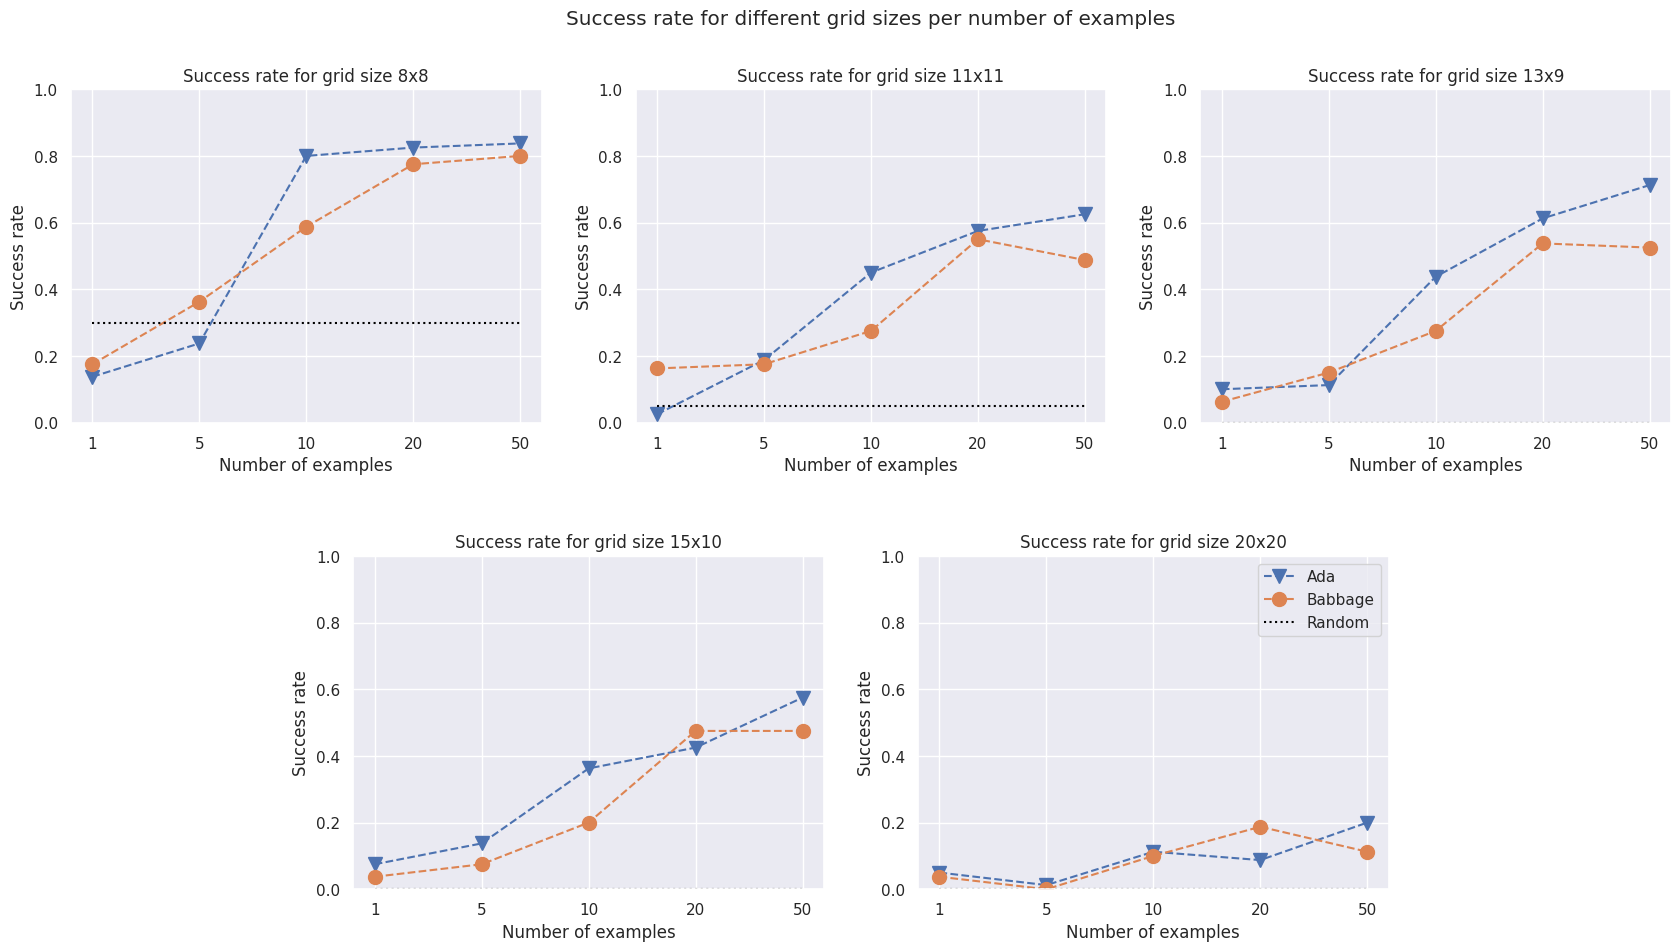

In [160]:
fig = plt.figure(figsize=(20, 10))
fig.tight_layout()

axs = []
axs.append(plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2))
axs.append(plt.subplot2grid((2,6), (0,2), colspan=2))
axs.append(plt.subplot2grid((2,6), (0,4), colspan=2))
axs.append(plt.subplot2grid((2,6), (1,1), colspan=2))
axs.append(plt.subplot2grid((2,6), (1,3), colspan=2))

lookup = [1, 5, 10, 20, 50]

for i, (grid, models) in enumerate(pre_processed_data.items()):
    ax = axs[i]
    
    ax.grid(True)    
    ax.set_title(f"Success rate for grid size {grid}")    
        
    ax.set_xlabel('Number of examples')
    ax.set_ylabel('Success rate')
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['1', '5', '10', '20', '50'])
    ax.set_ylim(0, 1)
    
    data_ada = np.nan_to_num(models['ada'][i*5: i*5+5])
    ax.plot(data_ada, label='Ada', linestyle='dashed', marker='v', markersize=10)
    
    data_babbage = np.nan_to_num(models['babbage'][i*5: i*5+5])
    ax.plot(data_babbage, label='Babbage', linestyle='dashed', marker='o', markersize=10)
    
    val = max(np.nan_to_num(models['random'][i*5: i*5+5]))
    
    data_random = [val]*5
    ax.plot(data_random, label='Random', linestyle='dotted', markersize=10, color='black')
    
fig.suptitle('Success rate for different grid sizes per number of examples')    
plt.legend()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=.4)
fig.show()